In [1]:
# --- Step 1: Setup & Data Inventory -----------------------------------------
# If needed, install deps:
# %pip install -q duckdb pandas pyarrow

import duckdb, pandas as pd, numpy as np, random, platform
from pathlib import Path


# Reproducibility
SEED = 42
np.random.seed(SEED); random.seed(SEED)

# Path to your DuckDB file
DB_PATH = Path("../data/warehouse.duckdb").resolve()
assert DB_PATH.exists(), f"Could not find DuckDB at: {DB_PATH}"

print("Python:", platform.python_version())
print("DuckDB:", duckdb.__version__)
print("DB file:", DB_PATH)

# Connect read-only (safety)
con = duckdb.connect(database=str(DB_PATH), read_only=True)

# List non-system tables/views
tables = con.execute("""
    SELECT table_schema, table_name, table_type
    FROM information_schema.tables
    WHERE table_schema NOT IN ('information_schema','pg_catalog')
    ORDER BY table_schema, table_name
""").df()
print("\nDiscovered objects:")
display(tables)

# Row counts per table (quick sense of scale)
counts = []
for _, r in tables.iterrows():
    qname = f'"{r.table_schema}"."{r.table_name}"'
    try:
        n = con.execute(f"SELECT COUNT(*) FROM {qname}").fetchone()[0]
    except Exception:
        n = None
    counts.append({"schema": r.table_schema, "table": r.table_name, "rows": n})
inventory = pd.DataFrame(counts).sort_values("rows", ascending=False).reset_index(drop=True)

print("\nRow counts:")
display(inventory)


Python: 3.13.5
DuckDB: 1.4.0
DB file: C:\Users\Asus\PycharmProjects\NEDCO_data_viz_app\data\warehouse.duckdb

Discovered objects:


,table_schema,table_name,table_type
0,prod,sales,BASE TABLE



Row counts:


,schema,table,rows
0,prod,sales,2867046


In [2]:
# --- Step 2: Schema & Sample Inspection -------------------------------------

# View table schema
schema_df = con.execute("DESCRIBE prod.sales").df()
print("Schema of prod.sales:")
display(schema_df)

# Peek at sample rows
sample_df = con.execute("SELECT * FROM prod.sales LIMIT 5").df()
print("\nSample rows:")
display(sample_df)


Schema of prod.sales:


,column_name,column_type,null,key,default,extra
0,chargedate,DATE,YES,None,None,None
1,meterid,BIGINT,YES,None,None,None
2,chargedate_str,VARCHAR,YES,None,None,None
3,loc,VARCHAR,YES,None,None,None
4,res,VARCHAR,YES,None,None,None
5,month,VARCHAR,YES,None,None,None
6,month_str,VARCHAR,YES,None,None,None
7,kwh,DOUBLE,YES,None,None,None
8,year,BIGINT,YES,None,None,None
9,ghc,DOUBLE,YES,None,None,None



Sample rows:


,chargedate,meterid,chargedate_str,loc,res,month,month_str,kwh,year,ghc,paymoney
0,2019-02-15,1,15-Feb-2019,Techiman [13],N-Resid [0],Feb-19,01-Feb-2019,14.2,2019,23.1705,140.0
1,2019-03-11,1,11-Mar-2019,Techiman [13],N-Resid [0],Mar-19,01-Mar-2019,57.4,2019,38.8886,40.0
2,2019-04-20,1,20-Apr-2019,Techiman [13],N-Resid [0],Apr-19,01-Apr-2019,57.4,2019,38.8886,20.0
3,2019-05-28,1,28-May-2019,Techiman [13],N-Resid [0],May-19,01-May-2019,57.4,2019,38.8886,20.0
4,2019-06-25,1,25-Jun-2019,Techiman [13],N-Resid [0],Jun-19,01-Jun-2019,57.4,2019,38.8886,20.0


In [3]:
# --- Step 3: Data Audit & Quality Check -------------------------------------

# 1) Basic metadata
meta = con.execute("""
    SELECT 
        COUNT(*) AS total_rows,
        COUNT(DISTINCT meterid) AS unique_meters,
        MIN(chargedate) AS min_date,
        MAX(chargedate) AS max_date
    FROM prod.sales
""").df()
print("Basic metadata:")
display(meta)

# 2) Missing values
nulls = con.execute("""
    SELECT 
        SUM(CASE WHEN chargedate IS NULL THEN 1 ELSE 0 END) AS n_chargedate,
        SUM(CASE WHEN meterid IS NULL THEN 1 ELSE 0 END) AS n_meterid,
        SUM(CASE WHEN kwh IS NULL THEN 1 ELSE 0 END) AS n_kwh,
        SUM(CASE WHEN paymoney IS NULL THEN 1 ELSE 0 END) AS n_paymoney
    FROM prod.sales
""").df()
print("\nMissing values:")
display(nulls)

# 3) Correlation
corr = con.execute("SELECT corr(kwh, paymoney) AS corr_kwh_paymoney FROM prod.sales").df()
print("\nCorrelation between kwh and paymoney:")
display(corr)

# 4) Duplicate row count (DuckDB-compatible)
#    Build COUNT(DISTINCT (<col1>, <col2>, ...)) over all columns
cols = [r[0] for r in con.execute("DESCRIBE prod.sales").fetchall()]
col_tuple = ", ".join([f'"{c}"' for c in cols])  # quote column names
dup_query = f"""
    SELECT COUNT(*) - COUNT(DISTINCT ({col_tuple})) AS duplicate_rows
    FROM prod.sales
"""
try:
    dupes = con.execute(dup_query).fetchone()[0]
    print(f"\nDuplicate rows (approx): {int(dupes)}")
except Exception as e:
    print("\nCould not compute duplicates in DuckDB; will defer to a Pandas sample check.")
    print("Reason:", e)


Basic metadata:


,total_rows,unique_meters,min_date,max_date
0,2867046,69065,2012-07-17,2022-08-04



Missing values:


,n_chargedate,n_meterid,n_kwh,n_paymoney
0,0.0,0.0,60943.0,39318.0



Correlation between kwh and paymoney:


,corr_kwh_paymoney
0,0.661713



Duplicate rows (approx): 0


In [4]:
# --- Step 5: Data Cleaning ---------------------------------------------------
import pandas as pd
import numpy as np

# Load data into memory
df = con.execute("SELECT * FROM prod.sales").df()
print("Initial shape:", df.shape)

# 1. Drop duplicates
before = len(df)
df = df.drop_duplicates()
print(f"Removed {before - len(df)} duplicate rows")

# 2. Drop rows with missing targets (kwh or paymoney)
before = len(df)
df = df.dropna(subset=["kwh", "paymoney"])
print(f"Removed {before - len(df)} rows with missing kwh/paymoney")

# 3. Convert data types
df["chargedate"] = pd.to_datetime(df["chargedate"], errors="coerce")
df["year"] = df["year"].astype(int)
df["kwh"] = df["kwh"].astype(float)
df["paymoney"] = df["paymoney"].astype(float)
df["ghc"] = df["ghc"].astype(float)

# 4. Standardize string columns
df["loc"] = df["loc"].str.strip().str.lower()
df["res"] = df["res"].str.strip().str.lower()

# 5. Remove non-positive consumption
before = len(df)
df = df[df["kwh"] > 0]
print(f"Removed {before - len(df)} rows with non-positive kwh")

# 6. Keep only relevant columns
keep_cols = ["meterid", "chargedate", "loc", "res", "year", "kwh", "ghc", "paymoney"]
df = df[keep_cols]

print("\nFinal cleaned shape:", df.shape)
display(df.head())


Initial shape: (2867046, 11)
Removed 0 duplicate rows
Removed 87030 rows with missing kwh/paymoney
Removed 0 rows with non-positive kwh

Final cleaned shape: (2780016, 8)


,meterid,chargedate,loc,res,year,kwh,ghc,paymoney
0,1,2019-02-15,techiman [13],n-resid [0],2019,14.2,23.1705,140.0
1,1,2019-03-11,techiman [13],n-resid [0],2019,57.4,38.8886,40.0
2,1,2019-04-20,techiman [13],n-resid [0],2019,57.4,38.8886,20.0
3,1,2019-05-28,techiman [13],n-resid [0],2019,57.4,38.8886,20.0
4,1,2019-06-25,techiman [13],n-resid [0],2019,57.4,38.8886,20.0


In [5]:
# --- Step 6A: quick numeric summary ----------------------------------------
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
meterid,2780016.0,NaN,NaN,NaN,30085.84151,1.0,9917.0,30880.0,47468.0,69065.0,20871.042426
chargedate,2780016,NaN,NaN,NaN,2018-02-19 04:22:17.420792,2012-07-17 00:00:00,2016-10-19 00:00:00,2018-07-25 00:00:00,2019-09-27 00:00:00,2022-08-04 00:00:00,NaN
loc,2780016,15,techiman [13],1445428,NaN,NaN,NaN,NaN,NaN,NaN,NaN
res,2780016,2,resid [1],2227875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2780016.0,NaN,NaN,NaN,2017.65181,2012.0,2016.0,2018.0,2019.0,2022.0,2.056437
kwh,2780016.0,NaN,NaN,NaN,121.506201,1.3,50.0,87.0,150.0,3878.0,136.904432
ghc,2780016.0,NaN,NaN,NaN,65.990304,0.9972,16.9953,38.8885,71.70399,4999.797,130.847653
paymoney,2780016.0,NaN,NaN,NaN,46.89956,0.0,15.0,30.0,50.0,3000.0,92.122613


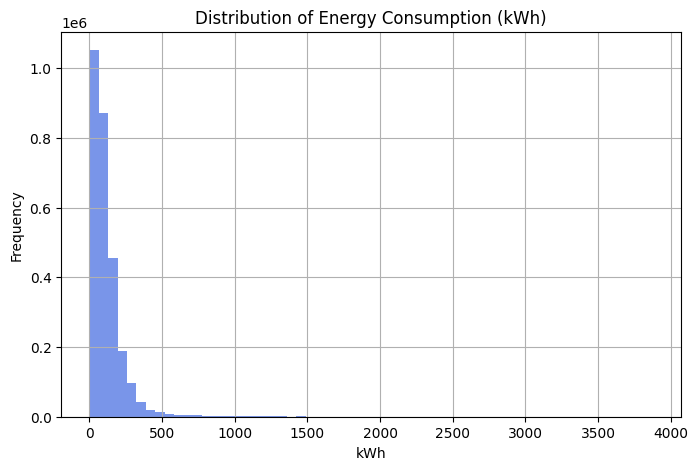

In [8]:
# --- Step 6B: Distribution of kWh ------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(df['kwh'], bins=60, color='royalblue', alpha=0.7)
plt.title('Distribution of Energy Consumption (kWh)')
plt.xlabel('kWh')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


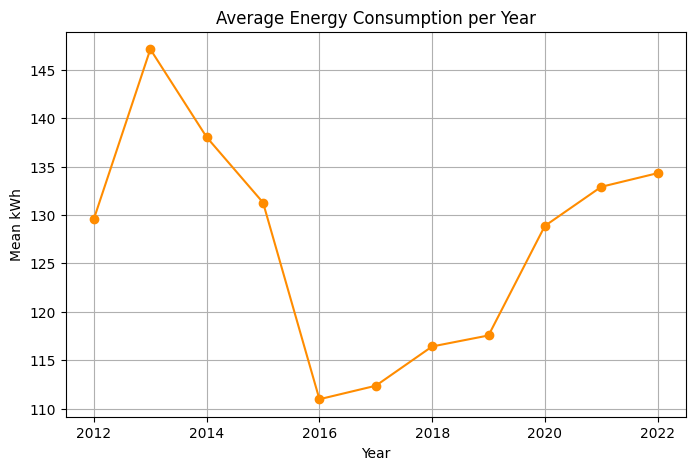

In [9]:
# --- Step 6C: Yearly Average Consumption Trend ------------------------------
yearly = df.groupby('year')['kwh'].mean()

plt.figure(figsize=(8,5))
plt.plot(yearly.index, yearly.values, marker='o', color='darkorange')
plt.title('Average Energy Consumption per Year')
plt.xlabel('Year')
plt.ylabel('Mean kWh')
plt.grid(True)
plt.show()


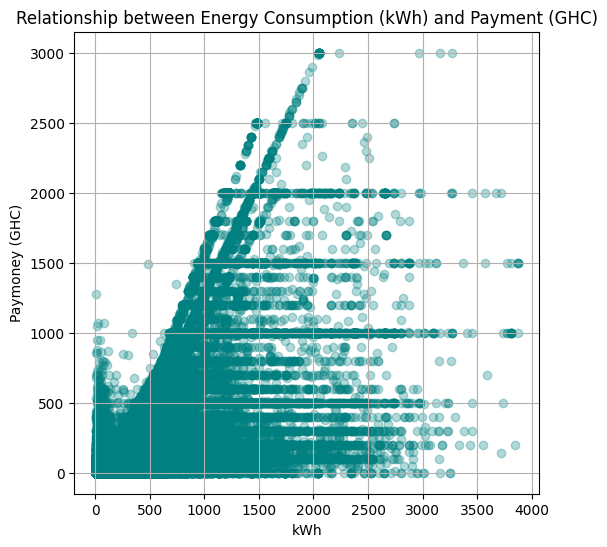

In [10]:
# --- Step 6D: Relationship between kWh and Paymoney -------------------------
plt.figure(figsize=(6,6))
plt.scatter(df['kwh'], df['paymoney'], alpha=0.3, color='teal')
plt.title('Relationship between Energy Consumption (kWh) and Payment (GHC)')
plt.xlabel('kWh')
plt.ylabel('Paymoney (GHC)')
plt.grid(True)
plt.show()


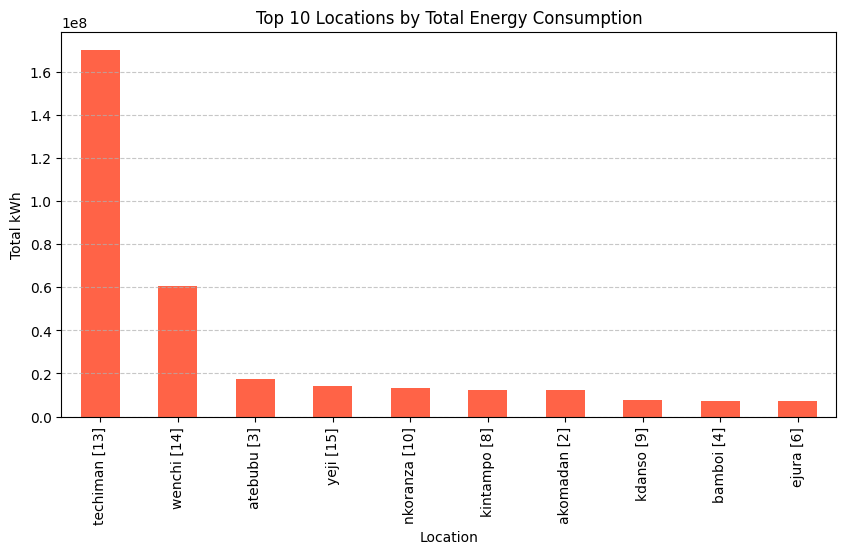

In [11]:
# --- Step 6E: Top 10 Locations by Total Consumption -------------------------
loc_top = (
    df.groupby('loc')['kwh']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10,5))
loc_top.plot(kind='bar', color='tomato')
plt.title('Top 10 Locations by Total Energy Consumption')
plt.xlabel('Location')
plt.ylabel('Total kWh')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


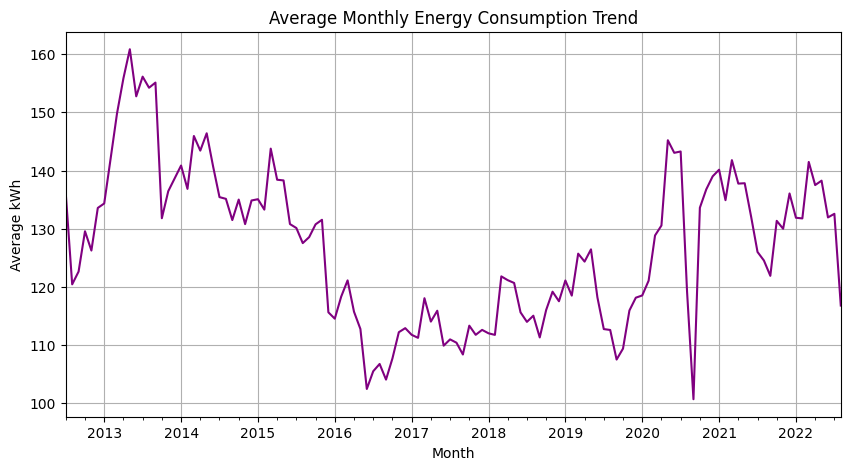

In [12]:
# --- Step 6F: Monthly Average Consumption Trend -----------------------------
monthly = df.groupby(df['chargedate'].dt.to_period('M'))['kwh'].mean()

plt.figure(figsize=(10,5))
monthly.plot(color='purple')
plt.title('Average Monthly Energy Consumption Trend')
plt.xlabel('Month')
plt.ylabel('Average kWh')
plt.grid(True)
plt.show()


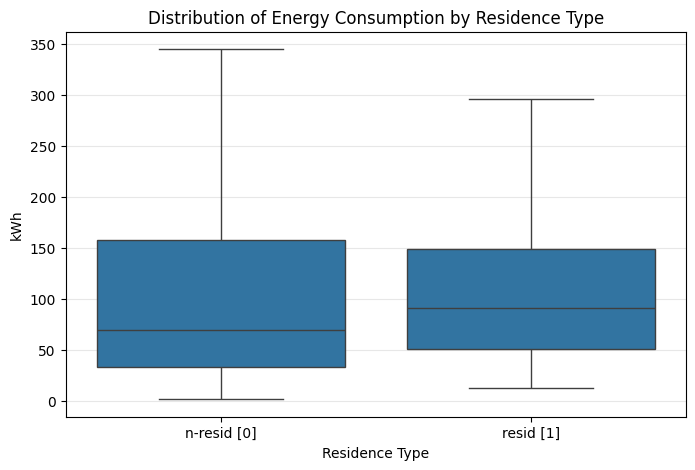

In [13]:
# --- Extended EDA 1: Boxplot of kWh by Residence Type -----------------------
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='res', y='kwh', data=df, showfliers=False)  # hide extreme outliers
plt.title('Distribution of Energy Consumption by Residence Type')
plt.xlabel('Residence Type')
plt.ylabel('kWh')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


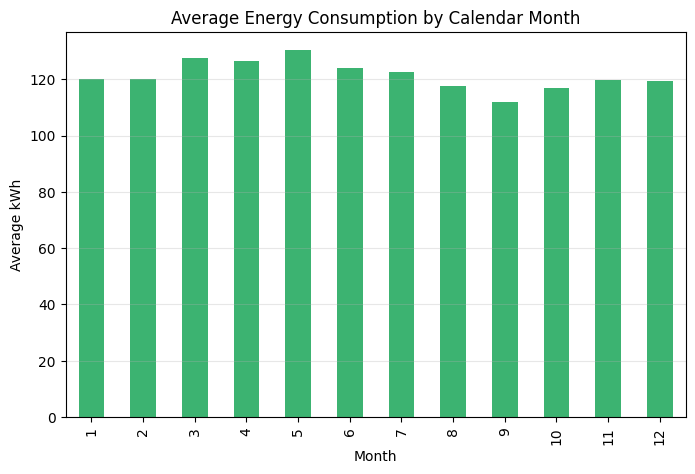

In [14]:
# --- Extended EDA 2: Average kWh by Month -----------------------------------
df['month'] = df['chargedate'].dt.month
month_avg = df.groupby('month')['kwh'].mean()

plt.figure(figsize=(8,5))
month_avg.plot(kind='bar', color='mediumseagreen')
plt.title('Average Energy Consumption by Calendar Month')
plt.xlabel('Month')
plt.ylabel('Average kWh')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


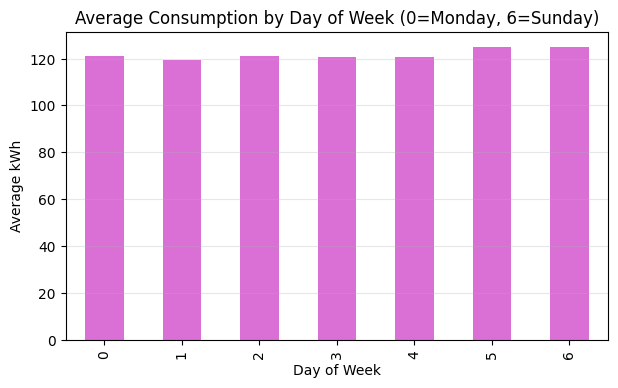

In [15]:
# --- Extended EDA 3: Average kWh by Day of Week -----------------------------
df['dayofweek'] = df['chargedate'].dt.dayofweek
dow_avg = df.groupby('dayofweek')['kwh'].mean()

plt.figure(figsize=(7,4))
dow_avg.plot(kind='bar', color='orchid')
plt.title('Average Consumption by Day of Week (0=Monday, 6=Sunday)')
plt.xlabel('Day of Week')
plt.ylabel('Average kWh')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


99th percentile of kWh: 654.90
Number of outlier records: 27798


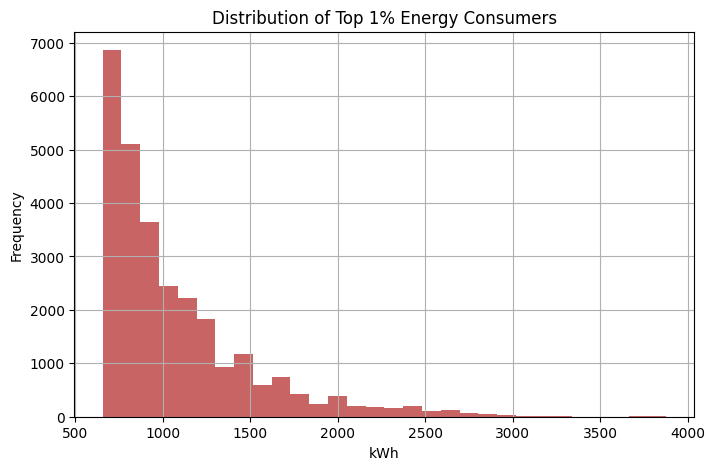

In [16]:
# --- Extended EDA 4: Outlier Consumption -----------------------------------
threshold = df['kwh'].quantile(0.99)
print(f"99th percentile of kWh: {threshold:.2f}")
top_outliers = df[df['kwh'] > threshold].copy()
print("Number of outlier records:", len(top_outliers))

plt.figure(figsize=(8,5))
plt.hist(top_outliers['kwh'], bins=30, color='firebrick', alpha=0.7)
plt.title('Distribution of Top 1% Energy Consumers')
plt.xlabel('kWh')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


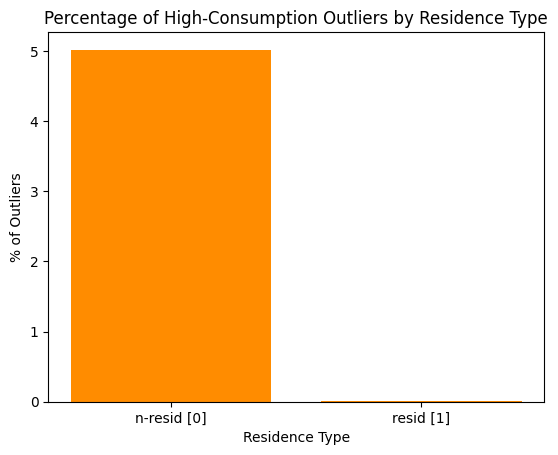

,res,is_outlier
0,n-resid [0],5.020095
1,resid [1],0.003591


In [17]:
# Identify top 1% consumers
threshold = df['kwh'].quantile(0.99)
df['is_outlier'] = (df['kwh'] > threshold).astype(int)

# Calculate ratio of outliers by residence
outlier_ratio = df.groupby('res')['is_outlier'].mean().reset_index()
outlier_ratio['is_outlier'] *= 100

plt.bar(outlier_ratio['res'], outlier_ratio['is_outlier'], color='darkorange')
plt.title('Percentage of High-Consumption Outliers by Residence Type')
plt.ylabel('% of Outliers')
plt.xlabel('Residence Type')
plt.show()

outlier_ratio


In [18]:
cutoff = '2020-09-01'

# Count records by location and residence type, pre- vs post-cutoff
loc_compare = (
    df.assign(period=np.where(df['chargedate'] < cutoff, 'Pre-2020-09', 'Post-2020-09'))
      .groupby(['period', 'loc', 'res'])
      .size()
      .reset_index(name='records')
      .sort_values(['period','records'], ascending=[True, False])
)

display(loc_compare.head(20))


,period,loc,res,records
25,Post-2020-09,techiman [13],resid [1],47384
27,Post-2020-09,wenchi [14],resid [1],12172
24,Post-2020-09,techiman [13],n-resid [0],9402
5,Post-2020-09,atebubu [3],resid [1],5245
19,Post-2020-09,nkoranza [10],resid [1],5073
3,Post-2020-09,akomadan [2],resid [1],4881
29,Post-2020-09,yeji [15],resid [1],4517
17,Post-2020-09,kintampo [8],resid [1],3938
26,Post-2020-09,wenchi [14],n-resid [0],3436
21,Post-2020-09,nsawkaw [11],resid [1],1802


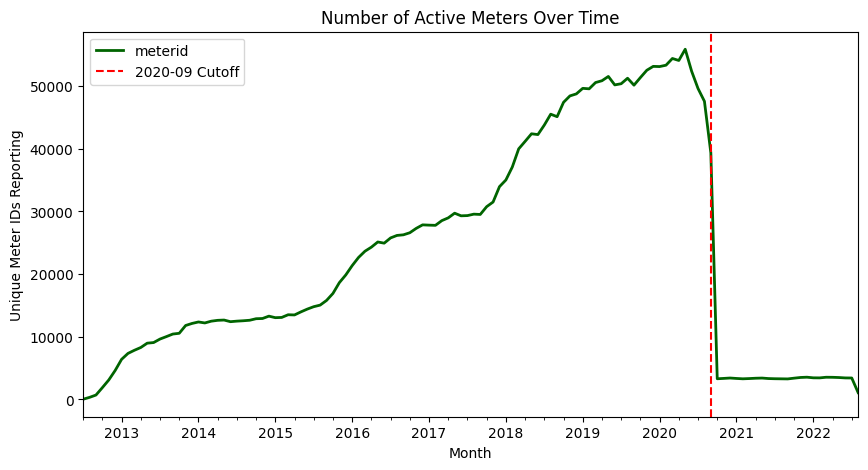

Active meters before 2020-09: 55,884
Active meters after 2020-09:  4,804
Percentage drop: 91.4%


In [19]:
# Count number of unique meters per month
meters_over_time = (
    df.groupby(df['chargedate'].dt.to_period('M'))['meterid']
      .nunique()
)

plt.figure(figsize=(10,5))
meters_over_time.plot(color='darkgreen', linewidth=2)
plt.axvline(pd.Period('2020-09'), color='red', linestyle='--', label='2020-09 Cutoff')
plt.title('Number of Active Meters Over Time')
plt.ylabel('Unique Meter IDs Reporting')
plt.xlabel('Month')
plt.legend()
plt.show()

# Print the numeric collapse for context
pre_meters = meters_over_time[meters_over_time.index < pd.Period('2020-09')].max()
post_meters = meters_over_time[meters_over_time.index >= pd.Period('2020-09')].mean()
print(f"Active meters before 2020-09: {pre_meters:,.0f}")
print(f"Active meters after 2020-09:  {post_meters:,.0f}")
print(f"Percentage drop: {(1 - post_meters/pre_meters)*100:.1f}%")


In [20]:
df_full = df[df['chargedate'] < '2020-09-01']      # 2012-2020 Full-coverage era
df_sparse = df[df['chargedate'] >= '2020-09-01']   # 2020-onward Sparse era


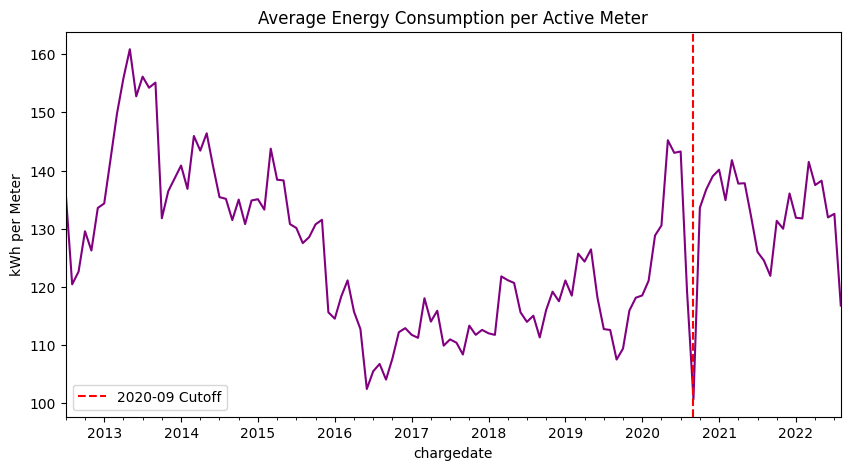

In [21]:
consumption_per_meter = (
    df.groupby(df['chargedate'].dt.to_period('M'))['kwh']
      .sum() /
    df.groupby(df['chargedate'].dt.to_period('M'))['meterid']
      .nunique()
)

consumption_per_meter.plot(figsize=(10,5), color='purple')
plt.axvline(pd.Period('2020-09'), color='red', linestyle='--', label='2020-09 Cutoff')
plt.title('Average Energy Consumption per Active Meter')
plt.ylabel('kWh per Meter')
plt.legend()
plt.show()


In [22]:
df = df[df['chargedate'] < '2020-09-01']


In [23]:
len(df)

2664718

Data retained: 2,664,718 rows
Date range after trim: 2012-07-17 00:00:00  →  2020-08-31 00:00:00


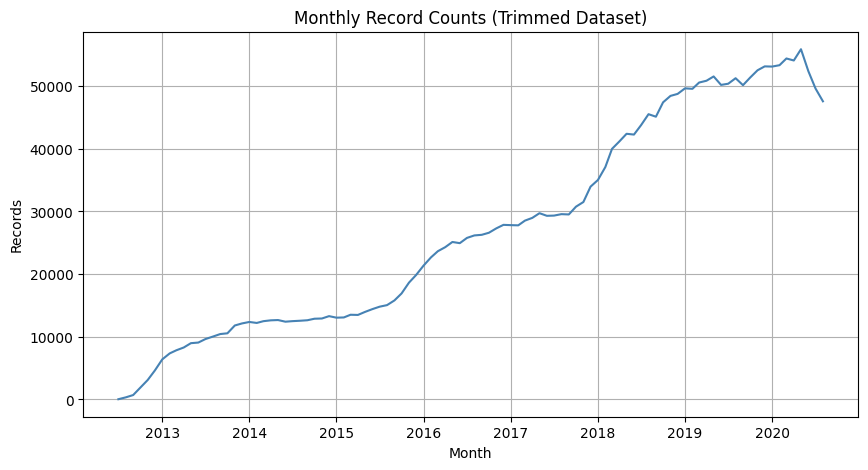

In [24]:
# --- Step X: Filter valid data period (before data feed collapse) ------------------

# Keep only data before Sept 2020
df = df[df['chargedate'] < '2020-09-01']

print(f"Data retained: {len(df):,} rows")
print(f"Date range after trim: {df['chargedate'].min()}  →  {df['chargedate'].max()}")

# Optional sanity check: verify data continuity
monthly_counts = (
    df.groupby(df['chargedate'].dt.to_period('M'))
      .size()
      .reset_index(name='records')
)
monthly_counts['chargedate'] = monthly_counts['chargedate'].dt.to_timestamp()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(monthly_counts['chargedate'], monthly_counts['records'], color='steelblue')
plt.title("Monthly Record Counts (Trimmed Dataset)")
plt.xlabel("Month")
plt.ylabel("Records")
plt.grid(True)
plt.show()


In [25]:
# --- Step 7: Feature Engineering ----------------------------------------------------
import pandas as pd
import numpy as np

# ✅ Ensure 'chargedate' is datetime
df['chargedate'] = pd.to_datetime(df['chargedate'])

# --- 1️⃣ Temporal Features ----------------------------------------------------------
df['year'] = df['chargedate'].dt.year
df['month'] = df['chargedate'].dt.month
df['day'] = df['chargedate'].dt.day
df['dayofweek'] = df['chargedate'].dt.dayofweek
df['week'] = df['chargedate'].dt.isocalendar().week.astype(int)
df['quarter'] = df['chargedate'].dt.quarter

# --- 2️⃣ Usage Ratios ---------------------------------------------------------------
df['pay_per_kwh'] = df['paymoney'] / df['kwh']          # how much is paid per unit energy
df['kwh_per_ghc'] = df['kwh'] / df['ghc']               # consumption per currency

# --- 3️⃣ Aggregated Historical Features ---------------------------------------------
# Average monthly kWh per meter (rolling or cumulative)
df = df.sort_values(['meterid', 'chargedate'])
df['monthly_kwh_mean'] = (
    df.groupby(['meterid', df['chargedate'].dt.to_period('M')])['kwh']
      .transform('mean')
)

# --- 4️⃣ Lag Features ---------------------------------------------------------------
# Previous month’s kWh for same meter (useful for forecasting)
df['prev_kwh'] = df.groupby('meterid')['kwh'].shift(1)
df['kwh_diff'] = df['kwh'] - df['prev_kwh']              # consumption change

# --- 5️⃣ Consumption Normalization ---------------------------------------------------
# Normalize kWh by yearly mean to handle scale differences
df['yearly_kwh_mean'] = df.groupby('year')['kwh'].transform('mean')
df['kwh_norm'] = df['kwh'] / df['yearly_kwh_mean']

# --- 6️⃣ Flags -----------------------------------------------------------------------
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['is_high_consumption'] = (df['kwh'] > df['kwh'].quantile(0.99)).astype(int)

print("Feature engineering completed!")
print(f"Total new features added: 10")
df.head()


Feature engineering completed!
Total new features added: 10


,meterid,chargedate,loc,res,year,kwh,ghc,paymoney,month,dayofweek,...,quarter,pay_per_kwh,kwh_per_ghc,monthly_kwh_mean,prev_kwh,kwh_diff,yearly_kwh_mean,kwh_norm,is_weekend,is_high_consumption
0,1,2019-02-15,techiman [13],n-resid [0],2019,14.2,23.1705,140.0,2,4,...,1,9.859155,0.612848,14.2,NaN,NaN,117.548509,0.120801,0,0
1,1,2019-03-11,techiman [13],n-resid [0],2019,57.4,38.8886,40.0,3,0,...,1,0.696864,1.476011,57.4,14.2,43.2,117.548509,0.488309,0,0
2,1,2019-04-20,techiman [13],n-resid [0],2019,57.4,38.8886,20.0,4,5,...,2,0.348432,1.476011,57.4,57.4,0.0,117.548509,0.488309,1,0
3,1,2019-05-28,techiman [13],n-resid [0],2019,57.4,38.8886,20.0,5,1,...,2,0.348432,1.476011,57.4,57.4,0.0,117.548509,0.488309,0,0
4,1,2019-06-25,techiman [13],n-resid [0],2019,57.4,38.8886,20.0,6,1,...,2,0.348432,1.476011,57.4,57.4,0.0,117.548509,0.488309,0,0


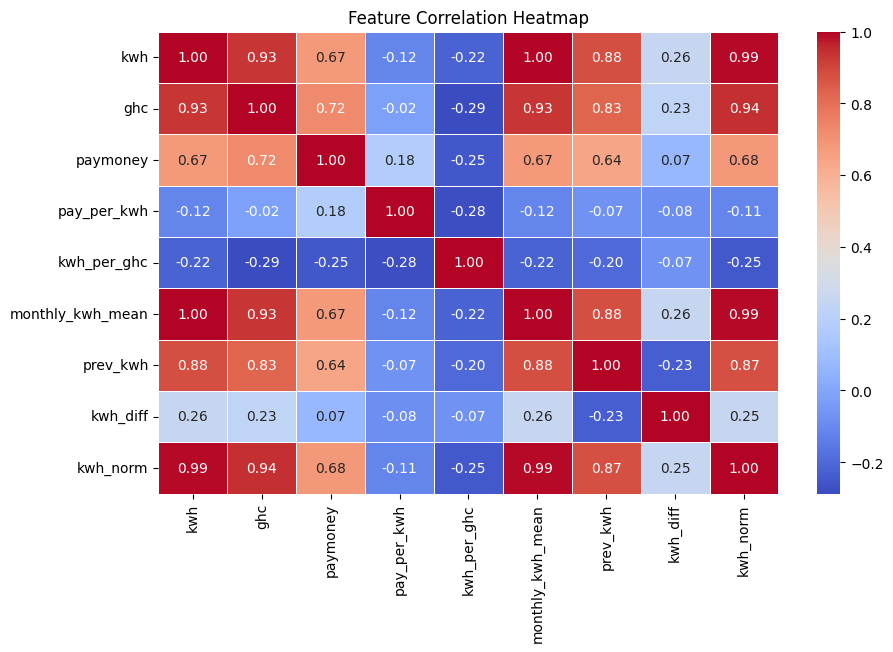


Top correlations with kWh:

kwh                 1.000000
monthly_kwh_mean    1.000000
kwh_norm            0.994309
ghc                 0.929953
prev_kwh            0.879825
paymoney            0.674966
kwh_diff            0.255641
pay_per_kwh        -0.115914
kwh_per_ghc        -0.221630
Name: kwh, dtype: float64


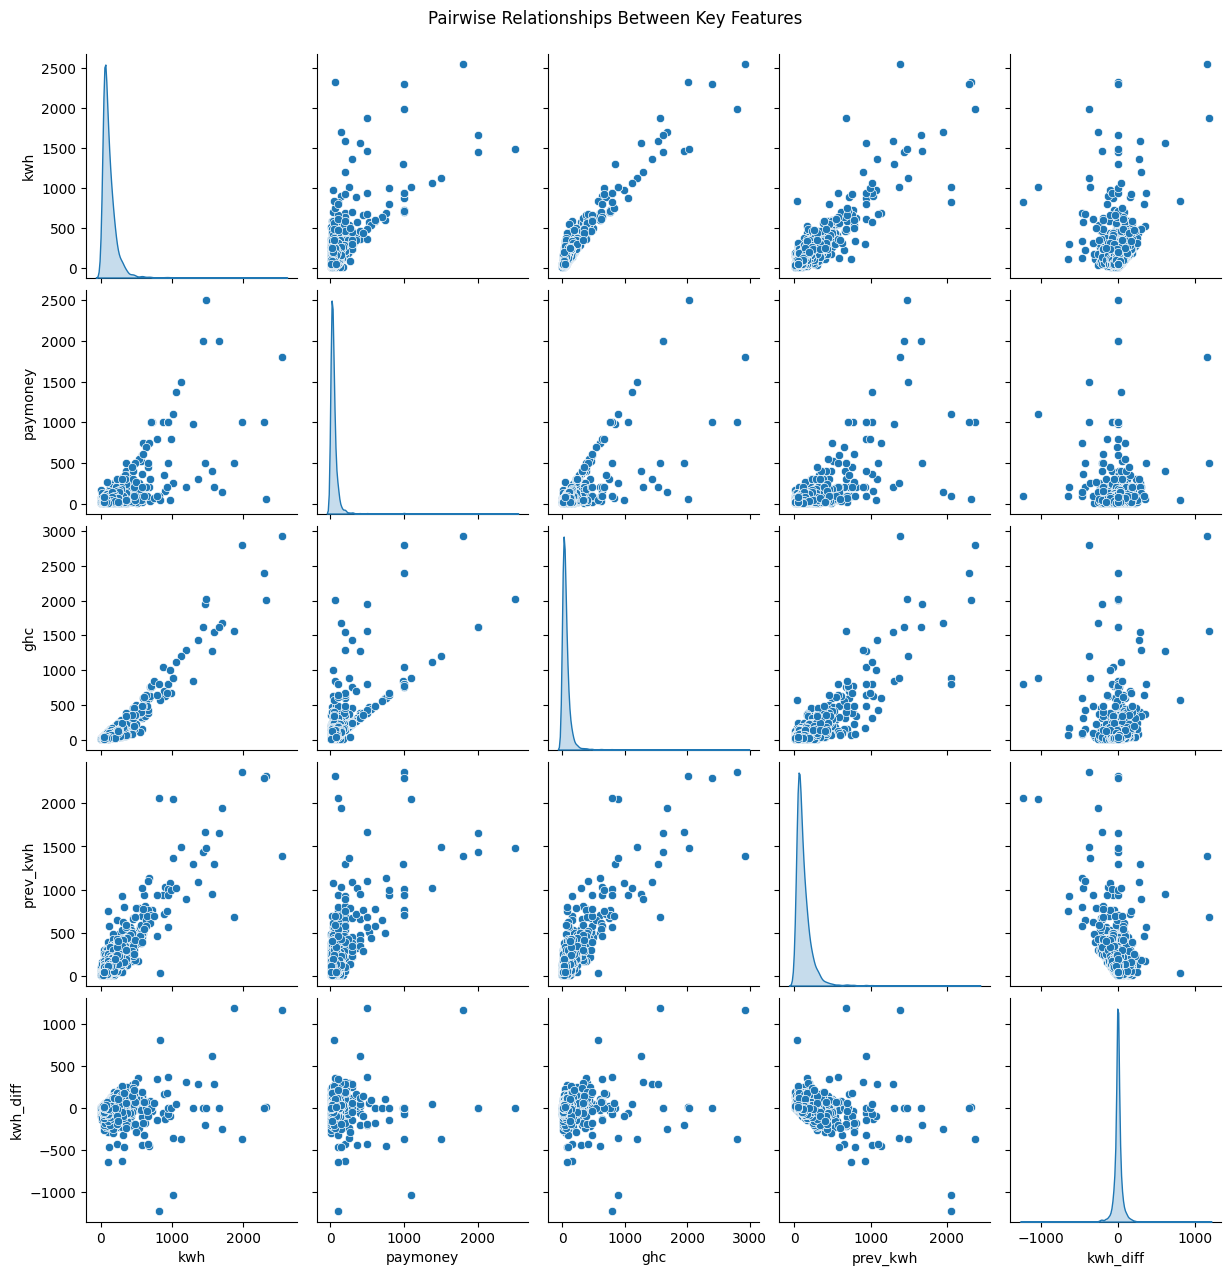

In [26]:
# --- Step 8: Feature Correlation & Importance Exploration ---------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns for correlation analysis
num_cols = ['kwh', 'ghc', 'paymoney', 'pay_per_kwh', 'kwh_per_ghc',
            'monthly_kwh_mean', 'prev_kwh', 'kwh_diff', 'kwh_norm']

corr_matrix = df[num_cols].corr()

# --- 1️⃣ Correlation Heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- 2️⃣ Top Correlations with kWh ---
corr_target = corr_matrix['kwh'].sort_values(ascending=False)
print("\nTop correlations with kWh:\n")
print(corr_target)

# --- 3️⃣ Pairplot for key relationships ---
key_features = ['kwh', 'paymoney', 'ghc', 'prev_kwh', 'kwh_diff']
sns.pairplot(df[key_features].sample(5000, random_state=42), diag_kind='kde')
plt.suptitle("Pairwise Relationships Between Key Features", y=1.02)
plt.show()


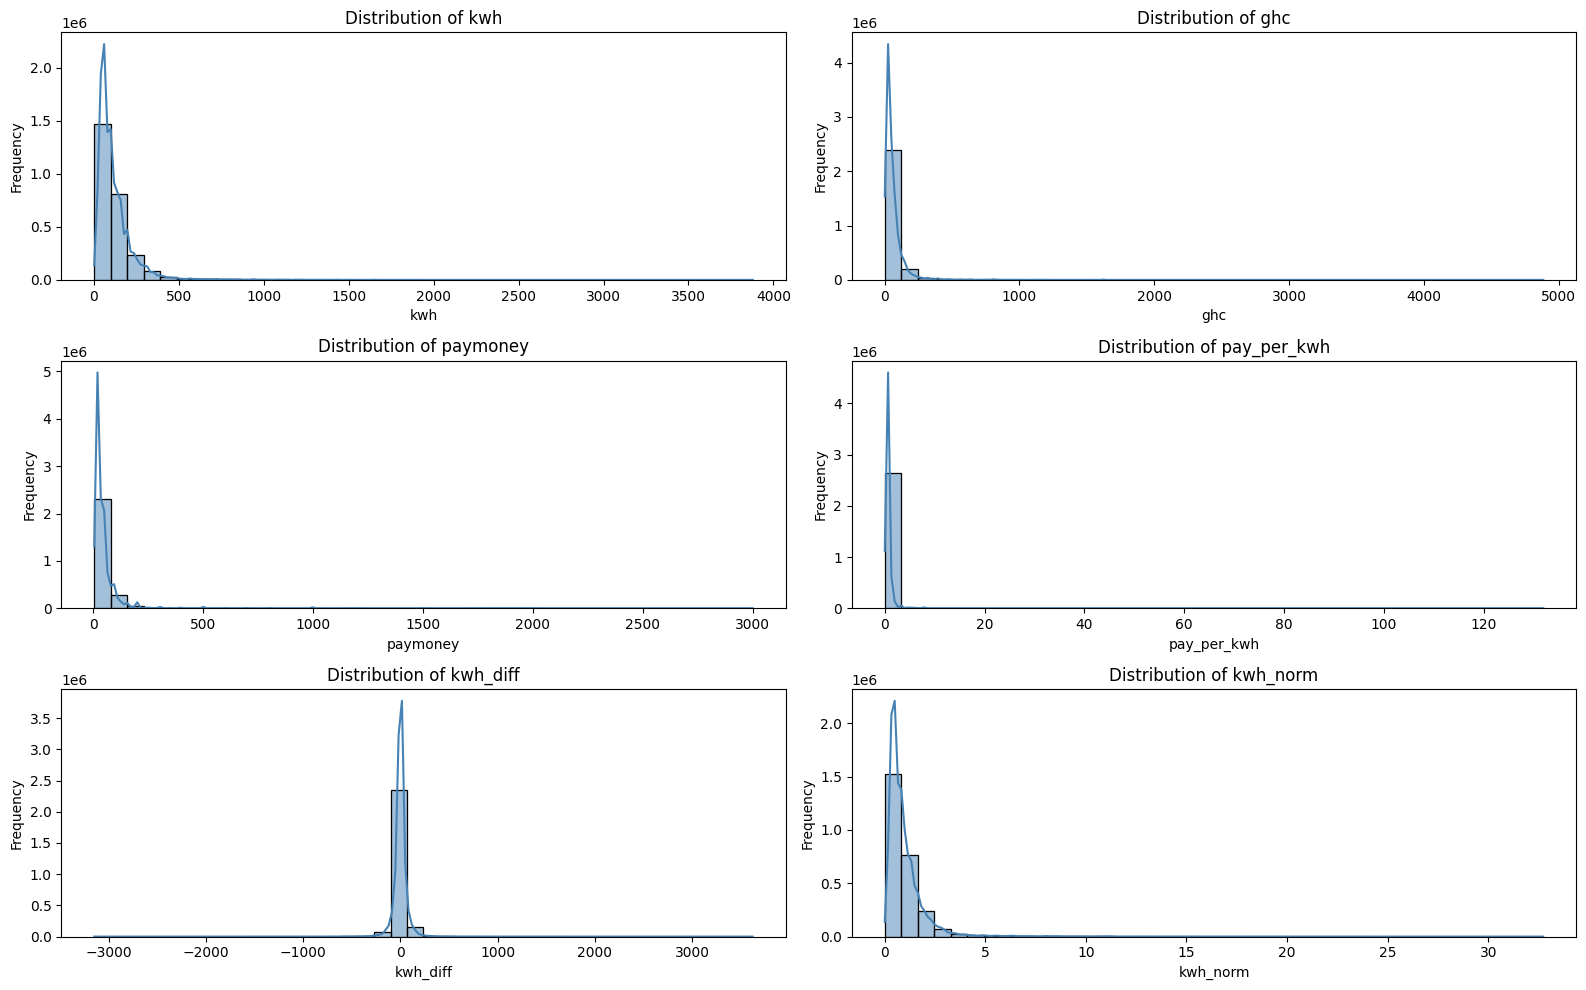

In [27]:
# --- Step 9.1: Feature Distribution Analysis -----------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

num_features = ["kwh", "ghc", "paymoney", "pay_per_kwh", "kwh_diff", "kwh_norm"]
plt.figure(figsize=(16, 10))

for i, col in enumerate(num_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=40, color="steelblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Outlier Summary:


,Feature,Outlier_Count,Outlier_%,Lower_Bound,Upper_Bound
0,kwh,146287,5.49,-99.970000,299.950000
1,ghc,169625,6.37,-65.257550,153.289250
2,paymoney,170780,6.41,-36.250000,101.750000
3,pay_per_kwh,194062,7.28,-0.247813,1.004914
4,kwh_diff,347162,13.03,-65.050000,68.150000
5,kwh_norm,150124,5.63,-0.751530,2.397908


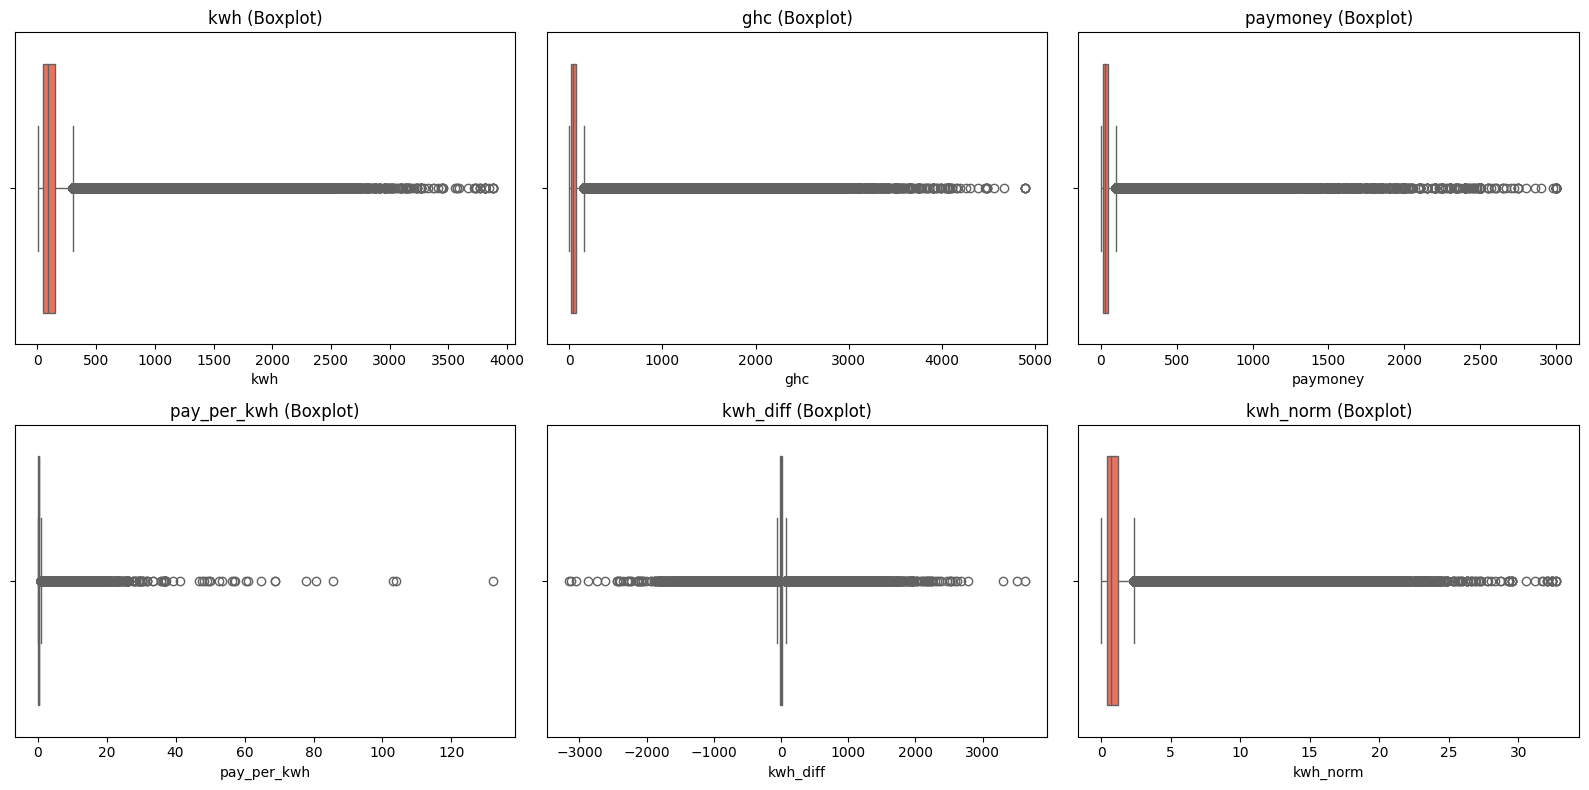

In [28]:
# --- Step 9.2: Outlier Detection & Visualization -----------------------------------

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    pct = (len(outliers) / len(df)) * 100
    return len(outliers), pct, lower_bound, upper_bound

# Apply to key numerical columns
features = ["kwh", "ghc", "paymoney", "pay_per_kwh", "kwh_diff", "kwh_norm"]
summary = []

for col in features:
    count, pct, lb, ub = detect_outliers(df, col)
    summary.append((col, count, round(pct, 2), lb, ub))

outlier_df = pd.DataFrame(summary, columns=["Feature", "Outlier_Count", "Outlier_%", "Lower_Bound", "Upper_Bound"])
print("Outlier Summary:")
display(outlier_df)

# Visualize with boxplots
plt.figure(figsize=(16, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color="tomato")
    plt.title(f"{col} (Boxplot)")
plt.tight_layout()
plt.show()



In [29]:
# --- Step 10 (Final Fix): Outlier Treatment with Numeric Enforcement -----------

import numpy as np
import pandas as pd

# Numeric columns
num_cols = ['kwh', 'ghc', 'paymoney', 'pay_per_kwh', 'kwh_diff', 'kwh_norm']

# Ensure numeric (unmask if necessary)
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check quantiles before winsorization
quantiles = df[num_cols].quantile([0.01, 0.99]).T
print("Pre-Winsorization quantiles:")
display(quantiles)

# Apply manual winsorization safely
for col in num_cols:
    lower = quantiles.loc[col, 0.01]
    upper = quantiles.loc[col, 0.99]
    df[col] = np.clip(df[col], lower, upper)

print("✅ Winsorization successfully reapplied (no flattening this time).")
display(df[num_cols].describe().T)


Pre-Winsorization quantiles:


,0.01,0.99
kwh,10.600000,657.880000
ghc,5.529200,535.922000
paymoney,5.000000,300.000000
pay_per_kwh,0.052029,2.845528
kwh_diff,-175.000000,172.340000
kwh_norm,0.085576,5.460680


✅ Winsorization successfully reapplied (no flattening this time).


,count,mean,std,min,25%,50%,75%,max
kwh,2664718.0,117.348027,103.275844,10.600000,50.000000,87.000000,149.980000,657.880000
ghc,2664718.0,59.837768,75.777706,5.529200,16.697500,38.291100,71.334200,535.922000
paymoney,2664718.0,43.458419,45.887838,5.000000,15.500000,30.000000,50.000000,300.000000
pay_per_kwh,2664718.0,0.459463,0.415406,0.052029,0.221959,0.373000,0.535141,2.845528
kwh_diff,2595812.0,0.766767,48.613986,-175.000000,-15.100000,0.000000,18.200000,172.340000
kwh_norm,2664718.0,0.966584,0.847916,0.085576,0.429509,0.723106,1.216869,5.460680


In [30]:
df[num_cols].nunique()


kwh             30196
ghc             97885
paymoney        11278
pay_per_kwh    148557
kwh_diff        95169
kwh_norm        61936
dtype: int64

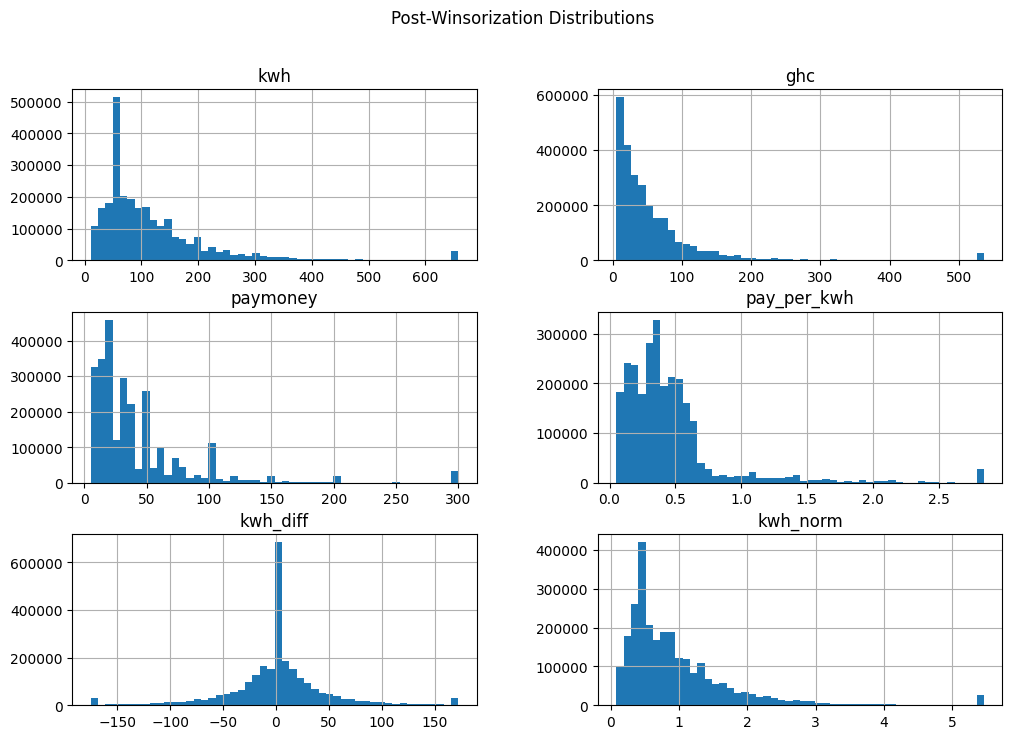

In [31]:
df[num_cols].hist(bins=50, figsize=(12, 8))
plt.suptitle("Post-Winsorization Distributions")
plt.show()


In [32]:
df = df.sort_values(['meterid', 'chargedate'])
df

,meterid,chargedate,loc,res,year,kwh,ghc,paymoney,month,dayofweek,...,quarter,pay_per_kwh,kwh_per_ghc,monthly_kwh_mean,prev_kwh,kwh_diff,yearly_kwh_mean,kwh_norm,is_weekend,is_high_consumption
0,1,2019-02-15,techiman [13],n-resid [0],2019,14.2,23.1705,140.0,2,4,...,1,2.845528,0.612848,14.2,NaN,NaN,117.548509,0.120801,0,0
1,1,2019-03-11,techiman [13],n-resid [0],2019,57.4,38.8886,40.0,3,0,...,1,0.696864,1.476011,57.4,14.2,43.2,117.548509,0.488309,0,0
2,1,2019-04-20,techiman [13],n-resid [0],2019,57.4,38.8886,20.0,4,5,...,2,0.348432,1.476011,57.4,57.4,0.0,117.548509,0.488309,1,0
3,1,2019-05-28,techiman [13],n-resid [0],2019,57.4,38.8886,20.0,5,1,...,2,0.348432,1.476011,57.4,57.4,0.0,117.548509,0.488309,0,0
4,1,2019-06-25,techiman [13],n-resid [0],2019,57.4,38.8886,20.0,6,1,...,2,0.348432,1.476011,57.4,57.4,0.0,117.548509,0.488309,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867040,69065,2020-04-18,abofour [1],resid [1],2020,56.7,45.2409,40.0,4,5,...,2,0.705467,1.253291,56.7,184.5,-127.8,131.320660,0.431768,1,0
2867041,69065,2020-05-06,abofour [1],resid [1],2020,133.4,106.4399,145.0,5,2,...,2,1.086957,1.253289,133.4,56.7,76.7,131.320660,1.015834,0,0
2867042,69065,2020-06-06,abofour [1],resid [1],2020,194.8,155.4309,155.0,6,5,...,2,0.795688,1.253290,194.8,133.4,61.4,131.320660,1.483392,1,0
2867043,69065,2020-07-02,abofour [1],resid [1],2020,174.4,139.1538,165.0,7,3,...,3,0.946101,1.253290,174.4,194.8,-20.4,131.320660,1.328047,0,0


In [33]:
df['kwh_lag1'] = df.groupby('meterid')['kwh'].shift(1)
df['kwh_lag2'] = df.groupby('meterid')['kwh'].shift(2)
df['kwh_diff'] = df['kwh'] - df['kwh_lag1']


In [34]:
train = df[df['chargedate'] < '2019-01-01']
test  = df[(df['chargedate'] >= '2019-01-01') & (df['chargedate'] < '2020-01-01')]


Shapes → (1633152, 16) (611176, 16)
dtypes sample:
 year         int32
month        int32
day          int32
dayofweek    int32
week         int64
dtype: object
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 1633152, number of used features: 16
[LightGBM] [Info] Start training from score 116.274630
MAE : 0.383
RMSE: 1.192
R²  : 0.9999


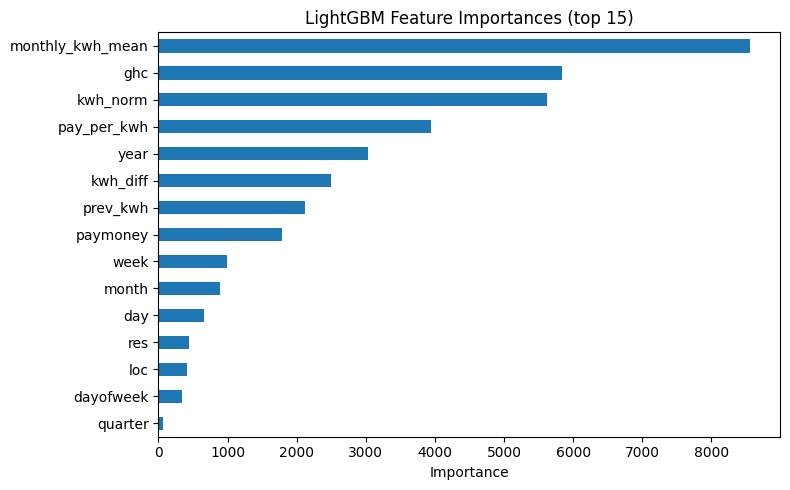

In [47]:
# --- Robust fix: numeric-only features (encode categoricals to codes) -------

import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Feature lists you already computed:
# num_feats, cat_feats
X_train = train[num_feats + cat_feats].copy()
X_test  = test[num_feats + cat_feats].copy()
y_train = train['kwh'].astype(float).copy()
y_test  = test['kwh'].astype(float).copy()

# 1) Encode categoricals to integer codes (no pandas CategoricalDtype left)
for c in cat_feats:
    # Ensure consistent category universe
    cats = pd.Index(sorted(pd.concat([X_train[c], X_test[c]]).dropna().unique()))
    X_train[c] = pd.Categorical(X_train[c], categories=cats).codes.astype('int32')
    X_test[c]  = pd.Categorical(X_test[c],  categories=cats).codes.astype('int32')

# 2) Ensure ALL remaining features are numeric (coerce if needed) & fill NaNs
for c in num_feats:
    X_train[c] = pd.to_numeric(X_train[c], errors='coerce')
    X_test[c]  = pd.to_numeric(X_test[c], errors='coerce')

X_train = X_train.fillna(0.0)
X_test  = X_test.fillna(0.0)

# Optional: verify no forbidden dtypes remain
non_numeric_cols_train = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric_cols_test  = X_test.select_dtypes(exclude=[np.number]).columns.tolist()
assert not non_numeric_cols_train, f"Non-numeric in X_train: {non_numeric_cols_train}"
assert not non_numeric_cols_test,  f"Non-numeric in X_test:  {non_numeric_cols_test}"

print("Shapes →", X_train.shape, X_test.shape)
print("dtypes sample:\n", X_train.dtypes.head())

# 3) Train LightGBM on pure numerics (no categorical_feature argument needed)
model = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X_train, y_train)

# 4) Evaluate
y_pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
from sklearn.metrics import r2_score
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:,.3f}")
print(f"RMSE: {rmse:,.3f}")
print(f"R²  : {r2:,.4f}")

# 5) Feature importances
import matplotlib.pyplot as plt
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
topk = importances.head(15)
plt.figure(figsize=(8,5))
topk.iloc[::-1].plot(kind='barh')
plt.title("LightGBM Feature Importances (top 15)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [49]:
# ========================== PREDICT FOR A FUTURE DATE =========================
# Assumptions:
# - `model` is your trained LightGBM model
# - `train` is the dataframe used to train (pre-2019/2020) with all engineered features
# - `num_feats` and `cat_feats` are the exact feature lists used to fit the model
# ==============================================================================

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

# Build category maps from TRAIN (so we encode future inputs the same way)
_cat_maps = {}
for c in [f for f in ['loc','res'] if f in train.columns]:
    cats = pd.Index(sorted(train[c].dropna().astype(str).unique()))
    _cat_maps[c] = {v:i for i, v in enumerate(cats)}

def _encode_cats_row(row_df: pd.DataFrame, cat_feats: list) -> pd.DataFrame:
    out = row_df.copy()
    for c in cat_feats:
        val = str(out.at[0, c])
        code = _cat_maps[c].get(val, -1)      # unseen -> -1
        out[c] = np.int32(code)
    return out

def _to_numeric_row(row_df: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = row_df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors='coerce')
    return out.fillna(0.0)

def predict_kwh_for_date(
    date, 
    model, 
    train_df, 
    num_feats, 
    cat_feats, 
    meterid=None, 
    loc=None, 
    res=None, 
    return_features=False
):
    """
    Predict kWh for a future date.
    
    Parameters
    ----------
    date : str or pd.Timestamp
        Future timestamp (e.g., '2019-02-01').
    model : fitted LightGBM model
    train_df : pd.DataFrame
        Training dataframe with engineered features.
    num_feats, cat_feats : list[str]
        Feature lists used during training.
    meterid : optional
        If provided, we base historical features on this meter's last record.
    loc, res : optional
        If meterid not provided, you can provide a location / residence hint.
    return_features : bool
        If True, also returns the single-row feature frame used for prediction.
    """
    date = pd.to_datetime(date)

    # ----- choose a "base row" to derive historical context -------------------
    if meterid is not None and 'meterid' in train_df.columns:
        df_ctx = train_df.loc[train_df['meterid'] == meterid]
        if df_ctx.empty:
            df_ctx = train_df
    elif loc is not None and 'loc' in train_df.columns:
        df_ctx = train_df.loc[train_df['loc'].astype(str) == str(loc)]
        if df_ctx.empty:
            df_ctx = train_df
        if res is not None and 'res' in train_df.columns:
            df_ctx2 = df_ctx.loc[df_ctx['res'].astype(str) == str(res)]
            if not df_ctx2.empty:
                df_ctx = df_ctx2
    else:
        df_ctx = train_df

    base = df_ctx.sort_values('chargedate').iloc[-1]  # last known record in the chosen context

    # ----- build the future feature row ---------------------------------------
    r = {}

    # categoricals
    for c in cat_feats:
        r[c] = base[c] if c in base else None

    # time features (align to what you trained with)
    r['year']       = date.year
    r['month']      = date.month
    r['day']        = date.day
    r['dayofweek']  = date.dayofweek
    r['week']       = int(date.isocalendar().week)
    r['quarter']    = (r['month'] - 1)//3 + 1
    r['is_weekend'] = int(r['dayofweek'] >= 5)

    # historical features (safe defaults)
    r['prev_kwh'] = float(base['kwh']) if 'kwh' in base else 0.0

    # monthly_kwh_mean: prefer last known, else recent meter mean, else global mean
    if 'monthly_kwh_mean' in base and pd.notna(base['monthly_kwh_mean']):
        r['monthly_kwh_mean'] = float(base['monthly_kwh_mean'])
    else:
        if ('meterid' in base) and ('meterid' in train_df.columns):
            m = base['meterid']
            r['monthly_kwh_mean'] = float(train_df.loc[train_df['meterid']==m, 'kwh'].tail(6).mean())
        else:
            r['monthly_kwh_mean'] = float(train_df['kwh'].mean())

    # kwh_diff (scenario; 0 = no change)
    r['kwh_diff'] = 0.0

    # kwh_norm (approx using prev_kwh / monthly mean)
    r['kwh_norm'] = float(r['prev_kwh'] / r['monthly_kwh_mean'] if r['monthly_kwh_mean'] else 0.0)

    # financials – proxy with last known values
    for c in ['ghc','paymoney','pay_per_kwh']:
        r[c] = float(base[c]) if (c in base and pd.notna(base[c])) else 0.0

    # assemble single-row DataFrame in the SAME feature order
    feature_cols = num_feats + cat_feats
    row = pd.DataFrame([r], columns=feature_cols)

    # encode categoricals to the same integer codes used at training
    if cat_feats:
        row = _encode_cats_row(row, cat_feats)

    # ensure numerics are numeric
    row = _to_numeric_row(row, num_feats)

    # predict
    y_hat = float(model.predict(row)[0])
    return (y_hat, row) if return_features else y_hat


In [50]:
# Example 1: predict for a specific future month (global context)
pred = predict_kwh_for_date('2019-02-01', model, train, num_feats, cat_feats)
print(f"Predicted kWh: {pred:.2f}")

# Example 2: predict for a given meter
pred_m = predict_kwh_for_date('2019-03-01', model, train, num_feats, cat_feats, meterid=123456)
print(f"Meter 123456 (2019-03-01) → kWh: {pred_m:.2f}")

# Example 3: get the feature row used (debugging/traceability)
pred_val, feat_row = predict_kwh_for_date('2019-04-01', model, train, num_feats, cat_feats, return_features=True)
print(pred_val)
display(feat_row)


Predicted kWh: 41.84
Meter 123456 (2019-03-01) → kWh: 41.81
41.82326391032283


,year,month,day,dayofweek,week,quarter,is_weekend,kwh_diff,prev_kwh,monthly_kwh_mean,kwh_norm,ghc,paymoney,pay_per_kwh,loc,res
0,2019,4,1,0,14,2,0,0.0,31.8,31.8,1.0,8.2871,10.0,0.314465,12,1


In [51]:
# Pre-load context once when app starts
from functools import partial

# 'train', 'model', 'num_feats', 'cat_feats' are loaded from training
predict_future_kwh = partial(
    predict_kwh_for_date,
    model=model,
    train_df=train,
    num_feats=num_feats,
    cat_feats=cat_feats
)


In [52]:
def user_predict_kwh(future_date: str):
    pred = predict_future_kwh(date=future_date)
    return f"Predicted kWh for {future_date}: {pred:.2f}"


In [53]:
def user_predict_kwh(future_date: str):
    pred = predict_future_kwh(date=future_date)
    return f"Predicted kWh for {future_date}: {pred:.2f}"

In [54]:
user_predict_kwh("2020-09-01")


'Predicted kWh for 2020-09-01: 41.82'

In [55]:
test["predicted_kwh"] = model.predict(test[features])

LightGBMError: The number of features in data (6) is not the same as it was in training data (16).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.